<a href="https://colab.research.google.com/github/cng-cod/nuclear_abnormalities/blob/main/Model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib

data_dir = "/content/drive/My Drive/enancib/celulas"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

72


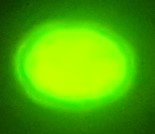

In [ ]:
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[0]))

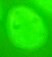

In [ ]:
normal = list(data_dir.glob('vacuolated/*'))
PIL.Image.open(str(normal[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 82 files belonging to 2 classes.
Using 66 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 82 files belonging to 2 classes.
Using 16 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['normal', 'vacuolated']


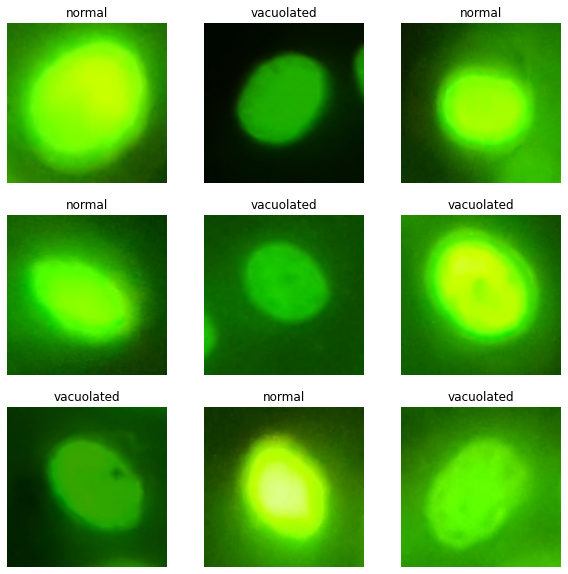

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [ ]:
IMG_SHAPE = 180
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 30976)            

In [ ]:
epochs=15


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 3s 1s/step - loss: 399.7656 - accuracy: 0.4545 - val_loss: 120.9566 - val_accuracy: 0.3750
Epoch 2/15
3/3 [==============================] - 2s 579ms/step - loss: 75.1690 - accuracy: 0.4545 - val_loss: 10.3046 - val_accuracy: 0.5625
Epoch 3/15
3/3 [==============================] - 2s 973ms/step - loss: 33.1718 - accuracy: 0.5303 - val_loss: 31.7031 - val_accuracy: 0.3750
Epoch 4/15
3/3 [==============================] - 2s 984ms/step - loss: 12.7629 - accuracy: 0.5758 - val_loss: 6.7815 - val_accuracy: 0.6250
Epoch 5/15
3/3 [==============================] - 2s 583ms/step - loss: 9.6402 - accuracy: 0.5152 - val_loss: 5.7101 - val_accuracy: 0.6250
Epoch 6/15
3/3 [==============================] - 2s 584ms/step - loss: 4.3209 - accuracy: 0.6364 - val_loss: 2.1168 - val_accuracy: 0.7500
Epoch 7/15
3/3 [==============================] - 2s 600ms/step - loss: 2.0508 - accuracy: 0.7273 - val_loss: 0.9398 - val_accuracy: 0.8125
Epoch 8/15
3/3

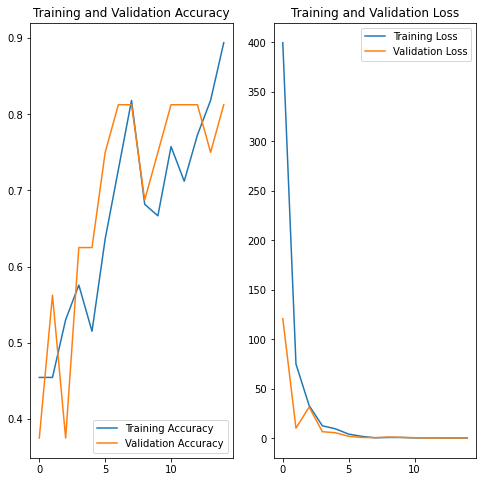

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
path = "/content/drive/My Drive/Image.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(180, 180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to vacuolated with a 100.00 percent confidence.


In [ ]:
path = "/content/drive/My Drive/Image1.jpg"

img = keras.preprocessing.image.load_img(
    path, target_size=(180, 180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to normal with a 76.39 percent confidence.
